***DEMO: GeoID class***
GEO_ID for lat,long = [-86.4111, 40.7073]: ['0500000US18017']
 

***DEMO: Raster class***
County border raster:


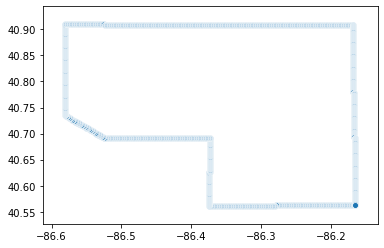

County surface raster:


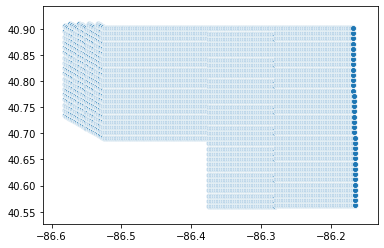

In [48]:

# - CONTOURS AS POLYGONS WITH MAP COORDINATES
# - LAT/LONG TO FIPS CONVERSION
# - RASTERING OF COUNTOURS AND SURFACES; FOR DATA PRESENTATION

## OS,I/O
import os
from urllib.request import urlopen
import json

## Process
import numpy as np
import pandas as pd
from collections import Counter

## Plot
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.figure_factory as ff

class GeoID:
    
    def __init__(self, path = './data', entities = ['counties'] ):
        self.path     = path + '/'
        self.entities = entities
        
        # Ensure path
        if not os.path.exists(path):
            os.mkdir(path)
        
        # Setup (initially exists only for counties - can add more)
        for entity in entities:
            string = 'self._setup_'+entity+'()'
            eval(string)
            
        # Required dictionaries: 
        #  self.coords_to_geoid_dic
        if os.path.exists(path+'_coords_to_geoid_dic.json'):
            self._coords_to_geoid_dic = read_json(path+'_coords_to_geoid_dic.json')
        else:
            self._coords_to_geoid_dic = {}
    
        # Function short names
        path          = self.path
        edges         = GeoID.edges
        shed_brackets = GeoID.shed_brackets
        save_as_json  = GeoID.save_as_json
        read_json     = GeoID.read_json
        

    def _setup_counties(self, data_url = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'):
        '''        
        Adds county-data to object:    
        * self.counties: (dict)
            - imported geojson info for counties, including names, GEO_IDs, shapes / polygon-coordinates
            - added min/max lat/long - values for counties
            - polygon-edges
        * self.df_geo: (pandas dataframe) self.counties as a dataframe 
        
        Ensures datafiles:
        * path/counties_fips.json  for self.counties
        * path/df_geo_counties.pkl for self.df_geo         
        '''
        # function short names
        path          = self.path
        edges         = GeoID.edges
        shed_brackets = GeoID.shed_brackets
        save_as_json  = GeoID.save_as_json
        read_json     = GeoID.read_json
        
        ##########
        # FETCH COUNTY DATA
        # Fetch Geo-data for counties; names, fips and shapes, vertex-coordinates for polygons 
        # If not on disk, fetch online and save to disk

        if not os.path.exists(path+'counties_fips.json'):
            with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
                counties = json.load(response)
            # ADD TO COUNTY-DATA: 1) POLYGON-EDGES . 2) MAX/MIN VALUES FOR LAT/LONG COORDS, RESPECTIVELY
            for county in counties['features']:
                vertex_list = county['geometry']['coordinates']
                county['geometry']['edges']    = {}
                county['geometry']['max_lat']  = {} 
                county['geometry']['min_lat']  = {}
                county['geometry']['max_long'] = {} 
                county['geometry']['min_long'] = {}
                # len(vertex_list) is the number of independent polygons for the county
                # in most cases len(vertex_list) = 1, but can be larger than one when several polygons are required 
                # for mapping the county - for example for a coastal county with islands. 
                for i in range(len(vertex_list)):
                    verts = vertex_list[i]
                    county['geometry']['edges'][i]    = edges(shed_brackets(verts))
                    lats,longs = np.transpose(np.array(verts))
                    county['geometry']['max_lat'][i]  = float(max(lats))
                    county['geometry']['min_lat'][i]  = float(min(lats))
                    county['geometry']['max_long'][i] = float(max(longs))
                    county['geometry']['min_long'][i] = float(min(longs) )
            save_as_json(counties,path+'counties_fips.json')
        self.counties = read_json(path+'counties_fips.json')

        if not os.path.exists(path+'df_geo_counties.pkl'):
            df_all = pd.DataFrame(counties['features'])
            df_geo = pd.DataFrame(df_all['geometry'].to_dict()).T
            df_geo.index = df_all['properties'].apply(lambda x: x['GEO_ID'])
            df_geo['max_lat']  = df_geo['max_lat'].apply(lambda x: max(x.values()))
            df_geo['min_lat']  = df_geo['min_lat'].apply(lambda x: min(x.values()))
            df_geo['max_long'] = df_geo['max_long'].apply(lambda x: max(x.values()))
            df_geo['min_long'] = df_geo['min_long'].apply(lambda x: min(x.values()))
            df_geo.to_pickle(path+'/df_geo_counties.pkl')
        df_geo = pd.read_pickle(path+'df_geo_counties.pkl')
        self.df_geo = df_geo
        return self


    ####
    # COORDS TO GEO_ID
    #
    # Selects the counties' min/max-lat/long squares that include the point coords
    # ToDo: narrow down to the county polygon(s) that include(s) coords         

    def coords_to_geoid(self, coords):
        '''
        input: lat.long   ,  output: county id (GEO_ID)
        
        Find GEO_ID/fips of map coordinates. 
        If conversion not available in lookup-table ( self._coords_to_geoid_dic ), 
        calculate the GEO_ID for 'coords' and add to lookup-table. 

        Algorithm: Draw a line from a point anywhere inside a polygon. It will cross the borders of the 
        polygon an odd number of times. Any other polygon's borders will be crossed an even number of times. 

        1. Pre-select all counties with max/min-lat/long that span the coordinate
        2. Create a dataframe with their polygon-edges
        3. Select all polygon edges spanning the input longitude 
        2. From these, select 
                a. all edges with latitudes *larger* than the input latitude, and
                b. all edges *spanning* the input latitude (these will be few). 
                    i.  Calculate the edge latitude at the point of the input longitude
                    ii. If it exceeds the input latitude, save it (otherwise discard)
        3. Count GEO_IDs for all selected edges (a+b above), return the GEO_ID with an odd number of counts
        '''
        result = self._coords_to_geoid_dic.get(coords)
        if type(result) is not np.ndarray:
            result = self._coords_to_geoid(coords)
        return result 

    def _coords_to_geoid(self, coords):
        '''
        input: lat.long   ,  output: county id (GEO_ID)

        Algorithm: Draw a line from a point anywhere inside a polygon. It will cross the borders of the 
        polygon an odd number of times. Any other polygon's borders will be crossed an even number of times. 

        1. Pre-select all counties with max/min-lat/long that span the coordinate
        2. Create a dataframe with their polygon-edges
        3. Select all polygon edges spanning the input longitude 
        2. From these, select 
                a. all edges with latitudes *larger* than the input latitude, and
                b. all edges *spanning* the input latitude (these will be few). 
                    i.  Calculate the edge latitude at the point of the input longitude
                    ii. If it exceeds the input latitude, save it (otherwise discard)
        3. Count GEO_IDs for all selected edges (a+b above), return the GEO_ID with an odd number of counts
        '''
        # Function short names
        path          = self.path
        edges         = GeoID.edges
        shed_brackets = GeoID.shed_brackets
        save_as_json  = GeoID.save_as_json
        read_json     = GeoID.read_json
    
        pre_select_fips = self._pre_select_fips
        lat,long = coords
        
        
        # Preselect counties with max/min-lat/long that include the coords
        df_counties = pre_select_fips(lat,long)
        df_counties['geo_id'] = df_counties.index
        counties = df_counties.T.to_dict()
        # Create a dataframe with all polygon-segments, tagged by GEO_ID (fips)   
        edges = {}
        def edg(poly_coords):
            '''
            edg: returns edges; the digram of the polygon-coordinates
            edg([a,b,c,d]) = [[a,b],[b,c],[c,d]]  where a/b/c/d = [lat,long]
            '''
            edges = [np.concatenate([poly_coords[i],poly_coords[i+1],[geo_id]]) for i in range(len(poly_coords)-1)]
            return edges 

        for county in counties.values():
            geo_id = county['geo_id']
            edges[geo_id] = np.concatenate([edg(shed_brackets(poly_coords)) for poly_coords in county['coordinates']])
        # create and save df_edges listing all polygon edges where each edge is labeled by the county GEO_ID
        df = pd.DataFrame(np.concatenate(list(edges.values())),columns = ['lat_1','long_1','lat_2','long_2','GEO_ID'])
        # All values in df are str, convert the polygon coordinates to numbers
        df[['lat_1', 'long_1', 'lat_2', 'long_2']] = df[['lat_1', 'long_1', 'lat_2', 'long_2']].applymap(eval)
        # Select all polygon edges spanning the input longitude 
        df = df[df['long_2'].apply(lambda x: x >= long ) ^ df['long_1'].apply(lambda x: x >= long )] 
        # Select all edges *spanning* the input latitude (need more processing) 
        dfx = df[df['lat_2'].apply(lambda x: x >= lat )  ^ df['lat_1'].apply(lambda x: x >= lat )].copy() 
        # Select all edges *exceeding* the input latitude
        df = df[df['lat_2'].apply(lambda x: x >= lat )  & df['lat_1'].apply(lambda x: x >= lat )]
        # If there are edges spanning the input latitude, select the ones 
        # exceeding the input latitude for the input longitude
        if len(dfx) > 0:
            def lat_larger(edge):
                kd = (edge['long_2'] - edge['long_1'])

                if kd > 0.0001:
                    kn = (edge['lat_2']  - edge['lat_1'])
                    k =  kn/kd
                    l = edge['lat_1']
                    x = long - edge['long_1']
                    y = k*x + l
                    if y >= lat:
                        return True
                    else:
                        return False
            dfx = dfx[dfx.T.apply(lat_larger)]
            df.append(dfx).reset_index(drop=True)
        # Count GEO_IDs, return the one with odd number of counts     
        crossings = pd.Series(Counter(df['GEO_ID']))
        geo_id = crossings[crossings%2 == 1].index.values
        self._coords_to_geoid_dic[coords] = geo_id
        return  geo_id
    
    def _pre_select_fips(self,lat,long):
        '''
        1. Pre-select all GEO_IDs with max/min-lat/long that span the coordinates lat,long
        2. Return a dataframe with their polygon-edges
        '''
        df = self.df_geo.copy()
        df = df[df['max_lat']  >= lat]
        df = df[df['max_long'] >= long]
        df = df[df['min_lat']  <= lat]
        df = df[df['min_long'] <= long] 
        return df   
    
    ## GENERAL PURPOSE FUNCTIONS
    def shed_brackets(bracketed_list):
        ''' 
        remove 'wrapping' brackets from list:  
            shed_brackets([[[[a]]]])              -> [a]
            shed_brackets([[[ [a,b,c]] ]])        -> [a,b,c]
            shed_brackets([[ [a,[b1,b2],c] ]])    -> [a,[b1,b2],c]
        '''
        # Function short names
        shed_brackets = GeoID.shed_brackets

        if len(bracketed_list) is 1: 
            # strip a bracket
            bracketed_list = shed_brackets(bracketed_list[0])
        if len(bracketed_list) is not 1:
            shedded_list = bracketed_list
        return shedded_list


    def edges(vertex_list):
        '''
        'edges()' returns the edges for a list of polygon-vertex coordinates. It is identical to digrams. 
        input [a,b,c,d]
        output [[a,b],[b,c],[c,d]]
        a/b/c is usually a list - the coordinates of vertex a/b/c respectively
        '''
        edge_list = [vertex_list[i:i+2] for i in range(len(vertex_list)-1)]
        return edge_list

    def save_as_json(variable,filename):
        '''
        Saves 'variable' as json-file 'filename'
        '''
        js = json.dumps(variable)
        f = open(filename,"w")
        f.write(js)
        f.close()
        return

    def read_json(filename):
        '''
        Reads 'variable' from json-file 'filename'
        '''
        with open(filename) as json_file:
            data = json.load(json_file)
            json_file.close()
        return data

if __name__ is '__main__': 
    print('***DEMO: GeoID class***')
    geo = GeoID()
    lat,long = -86.4111,40.7073
    geo_id = geo.coords_to_geoid((lat,long))
    print('GEO_ID for lat,long = '+str([lat,long])+': '+ str(geo_id)+'\n \n')

    
###############################################################################
    
# RASTER LINES AND POLYGON SURFACES

class Raster:
    
    def __init__(self,vertex_list):
        self.vertex_list = vertex_list
    
    def line(edge, step = 0.001):
        '''
        input:  edge - [start,end], where start and end are lists
        output: pixelated line
        '''
        start,end = edge
        scale = 1/step
        st     = np.array([int(i) for i in (scale * np.array(start))])
        en     = np.array([int(i) for i in (scale * np.array(end))])
        diff   = en - st
        x      = np.absolute(diff).argmax()
        n      = abs(diff[x])
        delta  = diff/n
        raster = ([np.round(i * delta) for i in range(n)] + st)/scale
        return raster

    def polygon(self, raster_surface = False, step=0.001, concatenate = True, return_result = False ):
        if type(self) is list:
            return_result = True
            self = Raster(self)        
        vertex_list = self.vertex_list
        self.polygon_edges = self._polygon_edges(step=step, concatenate_edges = concatenate)
        if raster_surface:
            self.polygon_surface = self._polygon_surface(step=step, concatenate_rows = concatenate)
        if return_result:
            if raster_surface:
                return self.polygon_surface
            else:
                return self.polygon_edges
        else:
            return self
            


    def _polygon_edges(self, step=0.001, concatenate_edges = True):
        '''
        input: list of polygon vertices
        '''
        df_edges        = pd.DataFrame(pd.Series(vertex_list[:-1]),columns = ['start'])
        df_edges['end'] = pd.Series(vertex_list[1:])
        raster     = np.array([Raster.line(edge,step=step) for edge in df_edges.values])
        if concatenate_edges:
            raster = np.concatenate(raster)
        return raster

    def _polygon_surface(self, step=0.001, concatenate_rows = True):
        vertex_list = self.vertex_list
        shape = self.polygon_edges
        dfm = pd.DataFrame(shape).groupby(0)
        df = dfm.min()
        df.columns = ['min']
        df['max'] = dfm.max()
        df['fill'] = df.apply(lambda x: np.arange(x['min'],x['max'],0.01),axis=1)
        df['n'] = df['fill'].apply(len)
        dic = df[df['n'] >0]['fill'].to_dict()
        fill = {}
        for item in dic.items():
            ix,x = item
            y = np.full(len(x),ix)
            row = np.transpose(np.array([y,x])) 
            fill[ix] = row
        fill = np.array(list(fill.values()))
        if concatenate_rows:
            fill = np.concatenate(fill)
        return fill    


if __name__ is '__main__': 
    print('***DEMO: Raster class***')
    print('County border raster:')
    vertex_list = GeoID.shed_brackets(geo.df_geo.loc[geo_id[0]]['coordinates'])
    rr = Raster.polygon(vertex_list,raster_surface = False)
    x,y = np.transpose(rr)
    sns.scatterplot(x,y)
    plt.show()
    print('County surface raster:')
    rr = Raster.polygon(vertex_list,raster_surface = True)
    x,y = np.transpose(rr)
    sns.scatterplot(x,y)
    plt.show()

    


In [42]:

vertex_list
# rr = Raster.polygon(vertex_list,raster_surface = True)

[[-86.165024, 40.562649],
 [-86.184044, 40.562459],
 [-86.374417, 40.561361],
 [-86.373521, 40.69246],
 [-86.525164, 40.692419],
 [-86.581739, 40.735765],
 [-86.581532, 40.910925],
 [-86.468509, 40.909889],
 [-86.169012, 40.909836],
 [-86.165024, 40.562649]]

In [25]:
geo.df_geo.loc[geo_id[0]]

coordinates    [[[-86.336776, 32.767469], [-86.31948, 32.7536...
edges          {0: [[[-86.336776, 32.767469], [-86.31948, 32....
max_lat                                                 -85.8799
max_long                                                 32.7675
min_lat                                                 -86.4133
min_long                                                 32.4099
type                                                     Polygon
Name: 0500000US01051, dtype: object

In [15]:
lat,long = -86.4111,32.7073
%time geo.coords_to_geoid((lat,long))

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 11.9 µs


array(['01051'], dtype=object)

In [6]:
lat = lat + 0.0001
%time geo.coords_to_geoid((lat,long))

CPU times: user 16 ms, sys: 2.03 ms, total: 18 ms
Wall time: 16.5 ms


array(['01051'], dtype=object)

In [24]:
geo.counties['features'][0]['properties']['GEO_ID']

'0500000US01001'

CPU times: user 9.2 ms, sys: 1.71 ms, total: 10.9 ms
Wall time: 9.71 ms


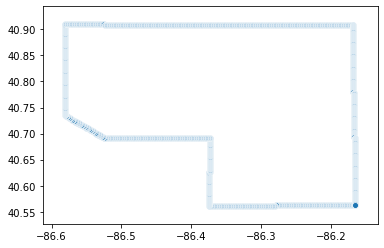

In [43]:
%time rr = Raster.polygon(vertex_list,raster_surface = False)
x,y = np.transpose(rr)
sns.scatterplot(x,y)

In [141]:
# SHORTER/SIMPLER CODE - DOES THE SAME AS ABOVE BUT *SLOWER*
#######
# COUNTIES DATA
# read dataframe with polygon-segments for counties. If it doesn't exist, create it. 
#######

# # 1. Check if df_edges pickle exists
# if not os.path.exists('./data/counties_df_edges.pkl'):
#     # If not:
#     # 1.1 Check if county data exists: GEO_ID (includes fips) and coordinates for polygon-vertices
#     if not os.path.exists('counties_fips_dict.txt'):
#         # If not:
#         # 1.1.1 Fetch county polygon data and save to disk:
#         with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#             counties = json.load(response)
#         file = open('./data/counties_fips_dict.txt','w')
#         file.write(str(counties))
#         file.close()
#     # 1.2. Read county data
#     file = open('counties_fips_dict.txt','r')
#     counties = eval(file.read())
#     file.close()

#     # 1.3. create a dataframe with all polygon-segments, tagged by GEO_ID    
#     edges = {}
#     def edg(poly_coords):
#         '''
#         edg: returns edges; the digram of the polygon-coordinates
#         edg([a,b,c,d]) = [[a,b],[b,c],[c,d]]  where a/b/c/d = [lat,long]
#         '''
#         edges = [np.concatenate([poly_coords[i],poly_coords[i+1],[geo_id]]) for i in range(len(poly_coords)-1)]
#         return edges 
    
#     for county in counties['features']:
#         geo_id = county['properties']['GEO_ID']
#         edges[geo_id] = np.concatenate([edg(shed_brackets(poly_coords)) for poly_coords in county['geometry']['coordinates']])
    
#     # create and save df_edges listing all polygon edges where each edge is labeled by the county GEO_ID
#     df_edges = pd.DataFrame(np.concatenate(list(edges.values())),columns = ['lat_1','long_1','lat_2','long_2','GEO_ID'])
#     df_edges[['lat_1','long_1','lat_2','long_2']] = df_edges[['lat_1','long_1','lat_2','long_2']].applymap(eval)
#     df_edges.to_pickle('./data/counties_df_edges.pkl')

# # 2. Read df_edges pickle
# df_edges = pd.read_pickle('./data/counties_df_edges.pkl')


# def coords_to_geoid(coords):
#     '''
#     input: lat.long   ,  output: county id (GEO_ID)
    
#     Algorithm: Draw a line from a point anywhere inside a polygon. It will cross the borders of the 
#     polygon an odd number of times. Any other polygon's borders will be crossed an even number of times. 
    
#     1. Select all polygon edges spanning the input longitude 
#     2. From these, select 
#             a. all edges with latitudes larger than the input latitude
#             b. all edges spanning the input latitude. 
#                 i.  Calculate the latitude of the edge corresponding to the input longitude
#                 ii. Select if the edge latitude exceeds the input latitude, otherwise discard
#     3. Count GEO_IDs for selected edges, return the GEO_ID with an odd number of counts
#     '''
#     # convert coordinates in string format to numbers
#     if type(coords) is str:
#         coords = eval(coords) 
#     lat,long = coords
#     df = df_edges.copy()
#     # Select all polygon edges spanning the input longitude 
#     df = df[df['long_2'].apply(lambda x: x >= long ) ^ df['long_1'].apply(lambda x: x >= long )] 
#     # Select all edges spanning the input latitude, 
#     dfx = df[df['lat_2'].apply(lambda x: x >= lat )  ^ df['lat_1'].apply(lambda x: x >= lat )].copy() 
#     # Select all edges exceeding the input latitude
#     df = df[df['lat_2'].apply(lambda x: x >= lat )  & df['lat_1'].apply(lambda x: x >= lat )]
#     # If there are edges spanning the input latitude, select the ones 
#     # exceeding the input latitude for the input longitude
#     if len(dfx) > 0:
#         def lat_larger(edge):
#             kd = (edge['long_2'] - edge['long_1'])

#             if kd > 0.0001:
#                 kn = (edge['lat_2']  - edge['lat_1'])
#                 k =  kn/kd
#                 l = edge['lat_1']
#                 x = long - edge['long_1']
#                 y = k*x + l
#                 if y >= lat:
#                     return True
#                 else:
#                     return False
#         dfx = dfx[dfx.T.apply(lat_larger)]
#         df.append(dfx).reset_index(drop=True)
#     # Count GEO_IDs, return the one with odd number of counts     
#     crossings = pd.Series(Counter(df['GEO_ID']))
#     odd_number_crossings = crossings[crossings%2 == 1].index.values
#     return odd_number_crossings

In [142]:
%time coords_to_geoid((-86.4111,32.7073))


CPU times: user 33 ms, sys: 2.61 ms, total: 35.7 ms
Wall time: 34.7 ms


array(['0500000US01051'], dtype=object)